In [39]:
import pandas as pd
import argparse
import logging
import json
import os
import pathlib
import fiona
import numpy as np
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from geopandas.tools import geocode
from shapely.geometry import Point
from shapely.geometry import shape
import requests
from zipfile import ZipFile
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

#import geojson

                                                    geometry
location                                                    
Isone      MULTIPOLYGON (((2718700.200 1110309.600, 27186...
Capriasca  MULTIPOLYGON (((2716429.100 1105940.400, 27164...
Massagno   MULTIPOLYGON (((2716259.400 1097097.600, 27162...


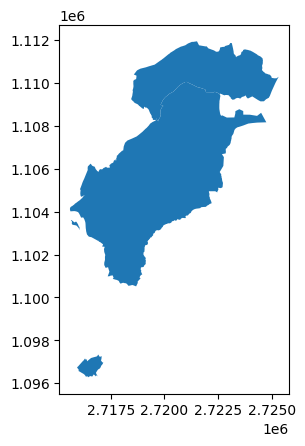

In [97]:
### AEM; ISONE = 5009 (district = 2101), CAPRIASCA = 5196 (district = 2105), MASSAGNO = 5226 (district = 2105)

DSO_comunes =["Isone", "Capriasca", "Massagno"]
tot = pd.DataFrame()

for com in DSO_comunes:
    url = 'https://api3.geo.admin.ch//rest/services/api/MapServer/find?'
    params = dict(
        layer='ch.swisstopo.swissboundaries3d-gemeinde-flaeche.fill',
        searchField='gemname',
        searchText= com,
        returnGeometry ="true",
        geometryFormat='geojson',
        sr='2056'
    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    data = res.json()
    geometry = data['results'][0]['geometry']
    geometry = shape(data['results'][0]['geometry'])

    gdf = gpd.GeoDataFrame(geometry=[geometry])
    #gdf["location"] = com
    #gdf = gdf.set_index("location")
    tot = pd.concat([tot,gdf],ignore_index=True)

tot["location"]= DSO_comunes
tot = tot.set_index("location")
print(tot)

# Plotting the MultiPolygon geometry
tot.plot()

# Display the plot
plt.show()

In [108]:
tot.type

location
Isone        MultiPolygon
Capriasca    MultiPolygon
Massagno     MultiPolygon
dtype: object

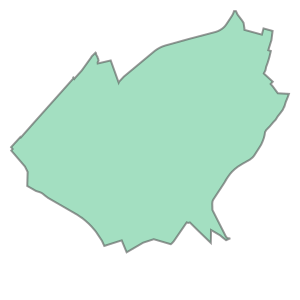

In [116]:
Massagno = tot.loc["Massagno","geometry"]
Massagno

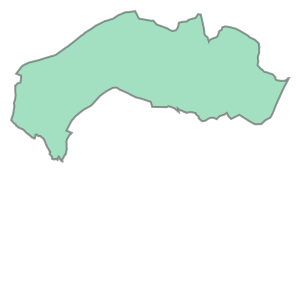

In [113]:
Isone = tot.loc["Isone","geometry"]
Isone

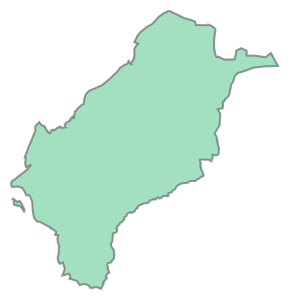

In [121]:
Capriasca = tot.loc["Capriasca","geometry"]
Capriasca

<Axes: >

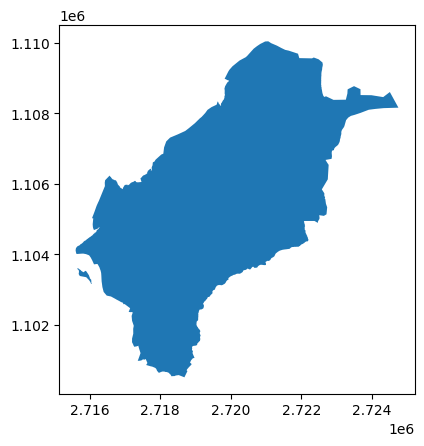

In [132]:
Cap_geo = gpd.GeoDataFrame(geometry=[shape(Capriasca)])
Cap_geo.plot()

In [110]:
pathlib.Path()
NOTEBOOK_PATH = pathlib.Path().resolve()
p = NOTEBOOK_PATH.parent
DATA_DIRECTORY = p / "data"
MAP_DIRECTORY = DATA_DIRECTORY /'maps'
BLDG_DIRECTORY = DATA_DIRECTORY /'Buildings_rea'

#SELECT CANTON
#CANTON = "Genève"
CANTON = "Ticino"

# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
SWISSTOPO_DISTRICT_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_BEZIRKSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html
SWISSTOPO_CANTON_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_KANTONSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html. NOTE: The actual shapefile (.shp) is useless without the companion files: .dbf, .shx, .prj etc..
### SWISSTOPO_CANTON_FILE = figureout how to get the municipal boundaries https://api3.geo.admin.ch/rest/services/api/MapServer/ch.swisstopo.swissboundaries3d-gemeinde-flaeche.fill

CANTON_FILE_PATH = MAP_DIRECTORY / SWISSTOPO_CANTON_FILE
DISTRICT_FILE_PATH = MAP_DIRECTORY / SWISSTOPO_DISTRICT_FILE

CANTON_CSV_DIRECTORY = BLDG_DIRECTORY / CANTON

# Read the gpkg file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
PLANT_DIRECTORY = DATA_DIRECTORY /'ElectricityProduction_EPSG2056'

### Read Canton file

In [9]:
canton_raw_limits = gpd.read_file(CANTON_FILE_PATH)
canton_limits = canton_raw_limits.to_crs(epsg=2056)
canton_selection = canton_limits[canton_limits.NAME == CANTON]
canton_selection = canton_selection[["NAME", "geometry"]]
canton_selection= canton_selection.reset_index()
canton_selection.at[0,"geometry"]
print(canton_selection)

   index    NAME                                           geometry
0      4  Ticino  POLYGON Z ((2727358.511 1119219.094 1351.527, ...


### Read the Districts geometries

In [10]:
# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
district_raw_limits = gpd.read_file(MAP_DIRECTORY/SWISSTOPO_DISTRICT_FILE)
district_limits = district_raw_limits.to_crs(epsg=2056)

### filter for District

In [12]:
Districts = district_limits[district_limits['KANTONSNUM'] == 21]
Districts = Districts[["NAME", "geometry"]].reset_index()

### get the PV plants

In [13]:
## double checking raw data - according to LINK there are XXX PV plants in TI
plants =  gpd.read_file(PLANT_DIRECTORY / "ElectricityProductionPlants.gpkg") #file downloaded from https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/e5a00bdb-5022-4856-ad4a-d1afe7bf38b0
PV_DATA = pd.DataFrame()

for i in range(len(Districts)):
    plants_in_district = plants[plants.within(Districts.at[i,"geometry"])]
    PV_DATA = pd.concat([PV_DATA, plants_in_district],ignore_index=True)
    
PV_plants_in_canton = PV_DATA.loc[PV_DATA["SubCategory"]== "subcat_2"]
print(len(PV_plants_in_canton))

8226


In [101]:
#plants_in_district = plants[plants.within(tot.at[2,"geometry"])]
DSO_PV = pd.DataFrame()

for com_pv in DSO_comunes:
    plants_in_comune = PV_plants_in_canton[PV_plants_in_canton.within(tot.at[com_pv,"geometry"])]
    DSO_PV = pd.concat([DSO_PV,plants_in_comune],ignore_index=True)

### Graphics for comunes

In [73]:
DSO_SFH_GEO = pd.DataFrame()
DSO_DFH_GEO = pd.DataFrame()
DSO_MFH_GEO = pd.DataFrame()
## enter UST_number of desired comune
### AEM; ISONE = 5009 (district = 2101), MASSAGNO = 5196 (district = 2105), CAPRIASCA = 5226 (district = 2105)
DSO_comunes_num =["5009", "5196", "5226"]

for COMUNE in DSO_comunes_num:

    SFH_comune_tocsv = COMUNE + "_bldg_SFH_PV_EGID.csv"
    DFH_comune_tocsv = COMUNE + "_bldg_DFH_PV_EGID.csv"
    MFH_comune_tocsv = COMUNE + "_bldg_MFH_PV_EGID.csv"

    COMUNE_SFH = pd.read_csv(CANTON_CSV_DIRECTORY/SFH_comune_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])
    COMUNE_RES_SFH = COMUNE_SFH.drop_duplicates(subset=['egid'])
    COMUNE_RES_SFH_GEO = gpd.GeoDataFrame(COMUNE_RES_SFH, geometry=gpd.points_from_xy(COMUNE_RES_SFH.gkode, COMUNE_RES_SFH.gkodn))   
    
    COMUNE_DFH = pd.read_csv(CANTON_CSV_DIRECTORY/DFH_comune_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])
    COMUNE_RES_DFH = COMUNE_DFH.drop_duplicates(subset=['egid'])
    COMUNE_RES_DFH_GEO = gpd.GeoDataFrame(COMUNE_RES_DFH, geometry=gpd.points_from_xy(COMUNE_RES_DFH.gkode, COMUNE_RES_DFH.gkodn))   
    
    COMUNE_MFH = pd.read_csv(CANTON_CSV_DIRECTORY/MFH_comune_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])
    COMUNE_RES_MFH = COMUNE_MFH.drop_duplicates(subset=['egid'])
    COMUNE_RES_MFH_GEO = gpd.GeoDataFrame(COMUNE_RES_MFH, geometry=gpd.points_from_xy(COMUNE_RES_MFH.gkode, COMUNE_RES_MFH.gkodn))
        
    COMUNE_RES = pd.concat([COMUNE_RES_SFH,COMUNE_RES_DFH ,COMUNE_RES_MFH],ignore_index= True)    
    COMUNE_RES = COMUNE_RES.drop_duplicates(subset=['egid'])
    COMUNE_RES_GEO = gpd.GeoDataFrame(COMUNE_RES, geometry=gpd.points_from_xy(COMUNE_RES.gkode, COMUNE_RES.gkodn))
    
    DSO_SFH_GEO = pd.concat([DSO_SFH_GEO,COMUNE_RES_SFH_GEO], ignore_index=True) 
    DSO_DFH_GEO = pd.concat([DSO_DFH_GEO,COMUNE_RES_DFH_GEO], ignore_index=True) 
    DSO_MFH_GEO = pd.concat([DSO_MFH_GEO,COMUNE_RES_MFH_GEO], ignore_index=True)     
    
DSO_RES_GEO =  pd.concat([DSO_SFH_GEO,DSO_DFH_GEO ,DSO_MFH_GEO],ignore_index= True)


In [149]:
def comune_geo(COMUNE, TYPOLOGY):
    comune_tocsv = COMUNE + "_bldg_"+ TYPOLOGY + "_PV_EGID.csv"

    COMUNE_RES = pd.read_csv(CANTON_CSV_DIRECTORY/comune_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])
    COMUNE_RES = COMUNE_RES.drop_duplicates(subset=['egid'])
    COMUNE_RES_GEO = gpd.GeoDataFrame(COMUNE_RES, geometry=gpd.points_from_xy(COMUNE_RES.gkode, COMUNE_RES.gkodn))
    
    return COMUNE_RES_GEO

In [151]:
ISONE_SFH = comune_geo("5009", "SFH")
ISONE_DFH = comune_geo("5009", "DFH")
ISONE_MFH = comune_geo("5009", "MFH")

MASSAGNO_SFH = comune_geo("5196", "SFH")
MASSAGNO_DFH = comune_geo("5196", "DFH")
MASSAGNO_MFH = comune_geo("5196", "MFH")

CAPRIASCA_SFH = comune_geo("5226", "SFH")
CAPRIASCA_DFH = comune_geo("5226", "DFH")
CAPRIASCA_MFH = comune_geo("5226", "MFH")

### By Municipality

(2718109.055, 2725667.045, 1108032.16, 1112125.04)

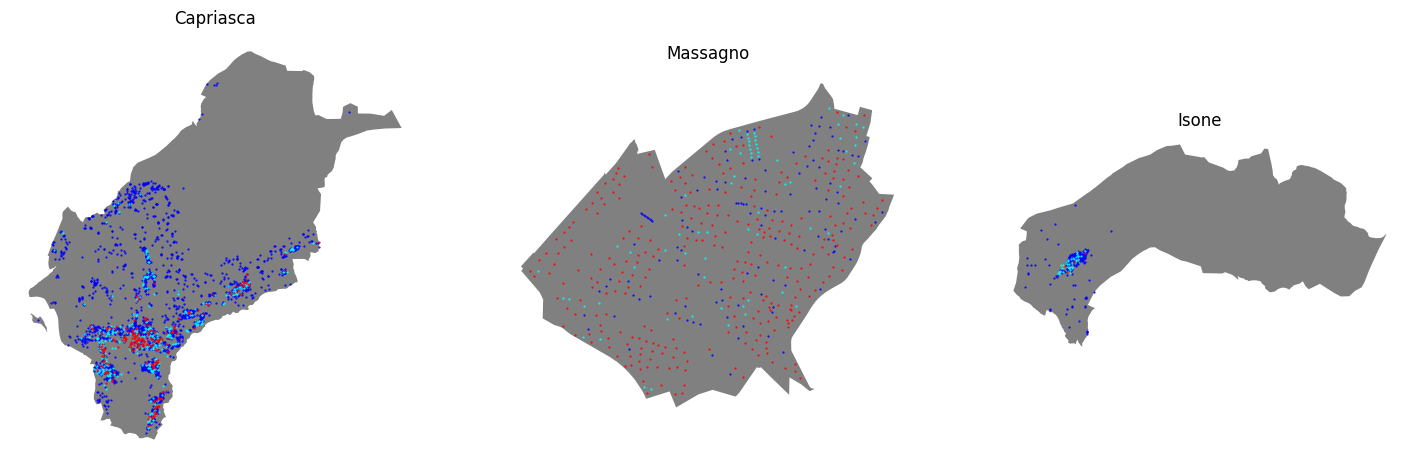

In [163]:
figure, (axis1, axis2, axis3) = plt.subplots(nrows=1, ncols=3, figsize=(18,8 ))

COM_geo_shape_1 = gpd.GeoDataFrame(geometry=[shape(Capriasca)])
COM_geo_shape.plot(ax=axis1, facecolor="grey")
CAPRIASCA_SFH.plot(ax=axis1, color="blue",markersize=0.3, label = "SFH")
CAPRIASCA_DFH.plot(ax=axis1, color="cyan",markersize=0.3, label = "DFH")
CAPRIASCA_MFH.plot(ax=axis1, color="red",markersize=0.3, label = "MFH")
axis1.set_title("Capriasca")
axis1.set_aspect(1)
axis1.axis("off")

COM_geo_shape_2 = gpd.GeoDataFrame(geometry=[shape(Massagno)])
COM_geo_shape_2.plot(ax=axis2, facecolor="grey")
MASSAGNO_SFH.plot(ax=axis2, color="blue",markersize=0.3, label = "SFH")
MASSAGNO_DFH.plot(ax=axis2, color="cyan",markersize=0.3, label = "DFH")
MASSAGNO_MFH.plot(ax=axis2, color="red",markersize=0.3, label = "MFH")
axis2.set_title("Massagno")
axis2.set_aspect(1)
axis2.axis("off")

COM_geo_shape_3 = gpd.GeoDataFrame(geometry=[shape(Isone)])
COM_geo_shape_3.plot(ax=axis3, facecolor="grey")
ISONE_SFH.plot(ax=axis3, color="blue",markersize=0.3, label = "SFH")
ISONE_DFH.plot(ax=axis3, color="cyan",markersize=0.3, label = "DFH")
ISONE_MFH.plot(ax=axis3, color="red",markersize=0.3, label = "MFH")
axis3.set_title("Isone")
axis3.set_aspect(1)
axis3.axis("off")


### By DSO

(2715111.725, 2725809.775, 1095495.0550000002, 1112722.045)

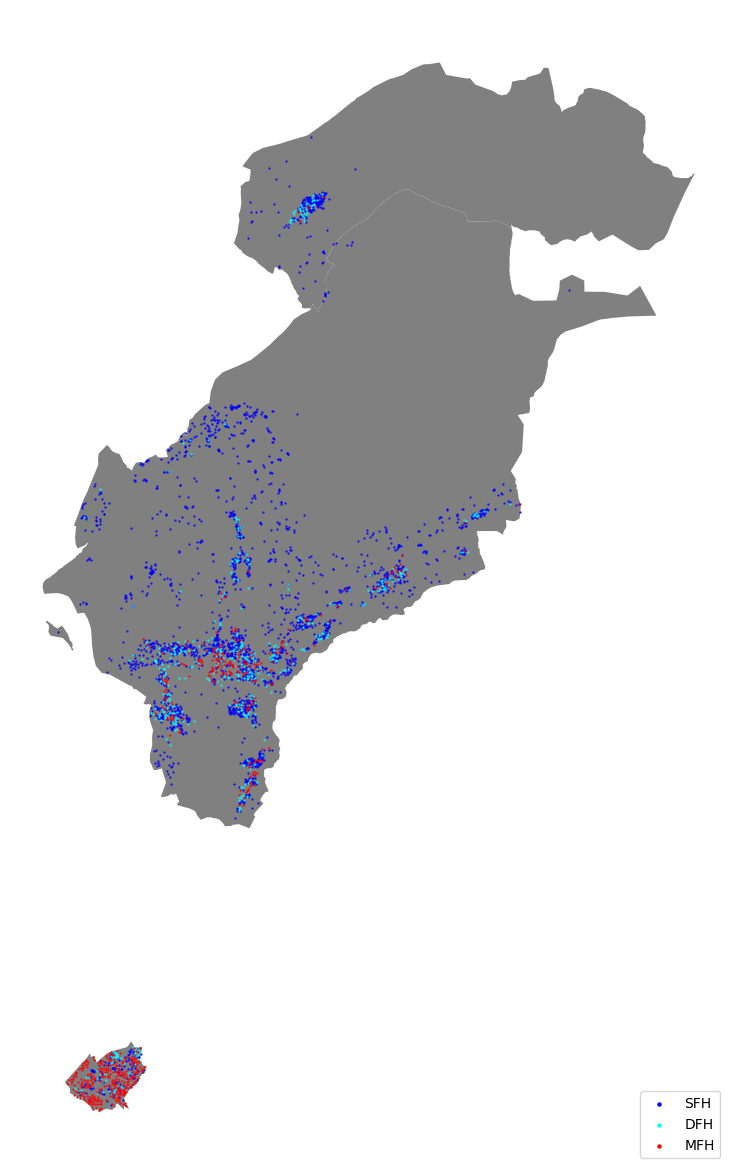

In [165]:
axes = tot.plot(facecolor="grey")
DSO_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
DSO_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
DSO_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
axes.legend(loc="lower right", markerscale=4)
plt.axis("off")

(2715111.725, 2725809.775, 1095495.0550000002, 1112722.045)

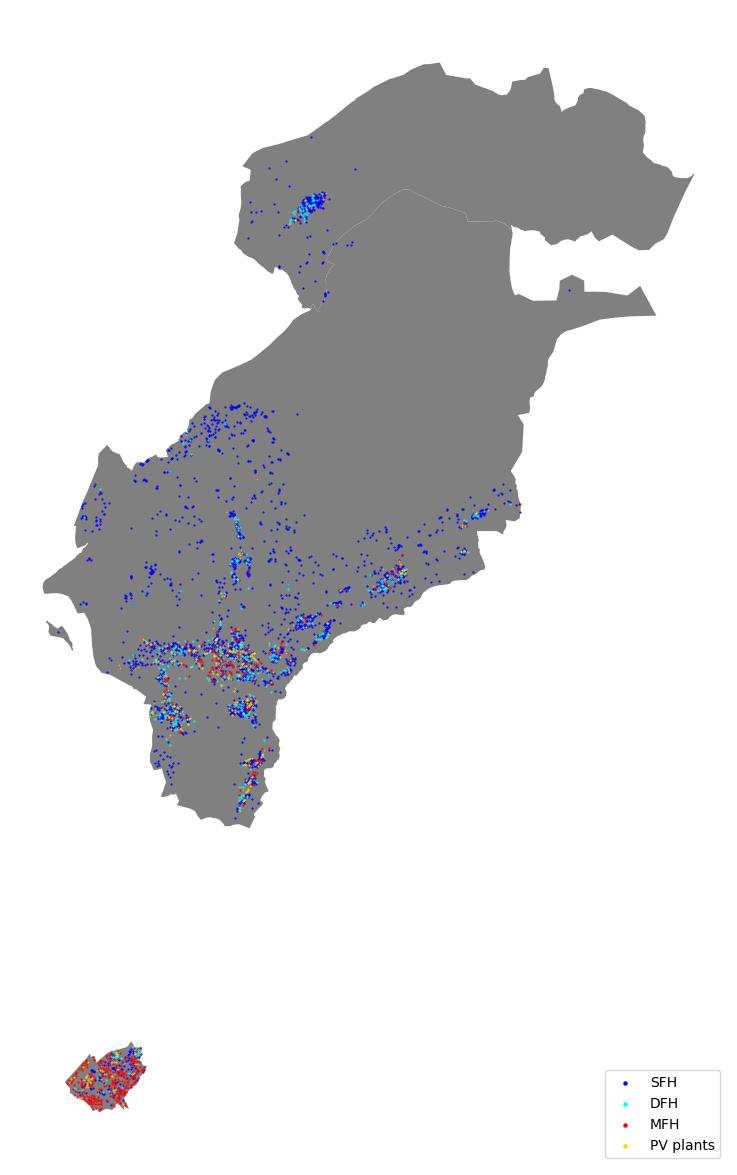

In [166]:
axes = tot.plot(facecolor="grey")
DSO_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
DSO_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
DSO_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
DSO_PV.plot(ax=axes, color="gold",markersize=0.3,label="PV plants")
axes.legend(loc="lower right", markerscale=4)
plt.axis("off")

(2715111.725, 2725809.775, 1095495.0550000002, 1112722.045)

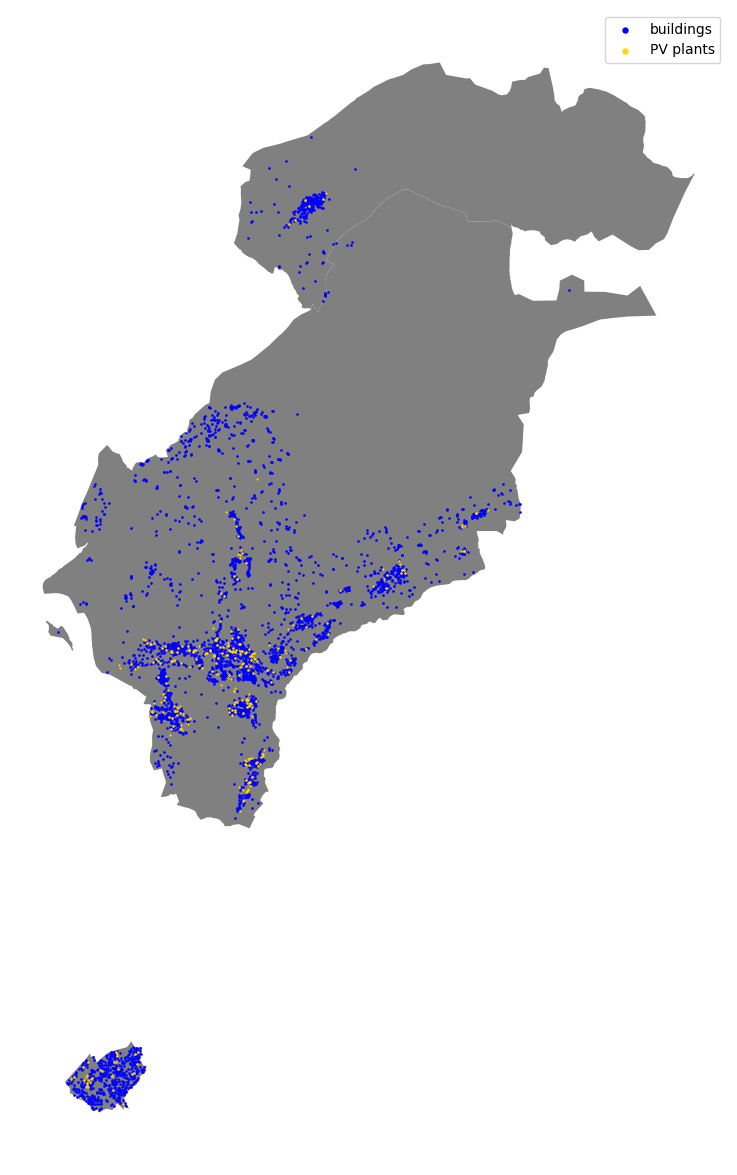

In [168]:
axes = tot.plot(facecolor="grey")
DSO_RES_GEO.plot(ax=axes, color="blue",markersize=0.8, label = "buildings")
DSO_PV.plot(ax=axes, color="gold",markersize=0.8,label="PV plants")
axes.legend(loc="best", markerscale=4)
plt.axis("off")